In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

In [5]:
df = pd.read_csv("dataset.csv")

In [6]:
df.describe()

,5.05
count,99.000000
mean,5.011919
std,0.323134
min,3.970000
25%,4.895000
50%,5.030000
75%,5.110000
max,7.140000


In [11]:
def plot_histogram_auto_bins(data, method='auto', **kwargs):
    """
    Автоматический выбор количества бинов с разными методами
    
    Parameters:
    data: данные для гистограммы
    method: метод выбора бинов ('auto', 'fd', 'doane', 'scott', 'rice', 'sturges')
    **kwargs: дополнительные параметры для гистограммы
    """
    plt.figure(figsize=(10, 6))
    
    n, bins, patches = plt.hist(data, bins=method, **kwargs)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    spline = CubicSpline(bin_centers, n)
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 300)
    y_smooth = spline(x_smooth)
    
    plt.plot(x_smooth, y_smooth, 'green', label='Сглаженная кривая')
    plt.title(f'Гистограмма (метод: {method}, бинов: {len(bins)-1})', fontsize=14)
    plt.xlabel(kwargs.get('xlabel', 'Значения'))
    plt.ylabel(kwargs.get('ylabel', 'Частота'))
    plt.grid(alpha=0.3)
    plt.show()
    
    print(f"Метод: {method}")
    print(f"Количество бинов: {len(bins)-1}")
    print(f"Границы бинов: {bins}")
    
    return n, bins


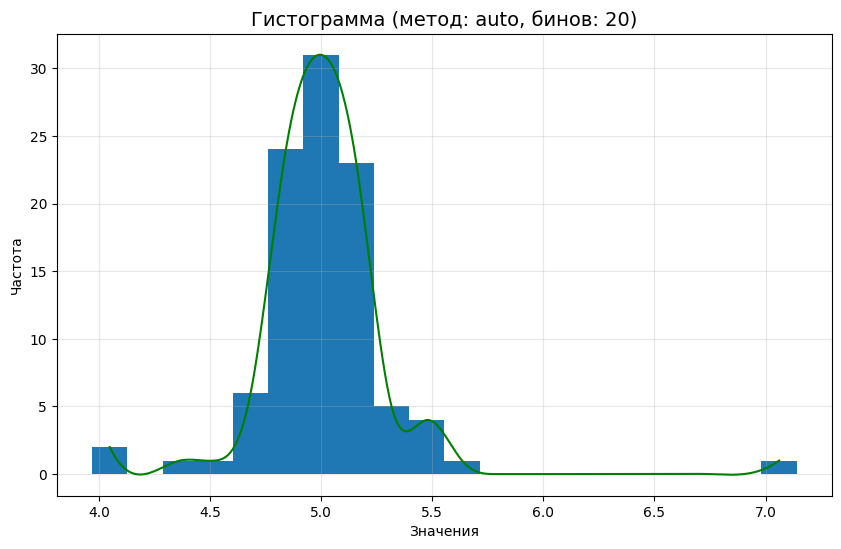

Метод: auto
Количество бинов: 20
Границы бинов: [3.97   4.1285 4.287  4.4455 4.604  4.7625 4.921  5.0795 5.238  5.3965
 5.555  5.7135 5.872  6.0305 6.189  6.3475 6.506  6.6645 6.823  6.9815
 7.14  ]


(array([ 2.,  0.,  1.,  1.,  6., 24., 31., 23.,  5.,  4.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3.97  , 4.1285, 4.287 , 4.4455, 4.604 , 4.7625, 4.921 , 5.0795,
        5.238 , 5.3965, 5.555 , 5.7135, 5.872 , 6.0305, 6.189 , 6.3475,
        6.506 , 6.6645, 6.823 , 6.9815, 7.14  ]))

In [12]:
plot_histogram_auto_bins(df)

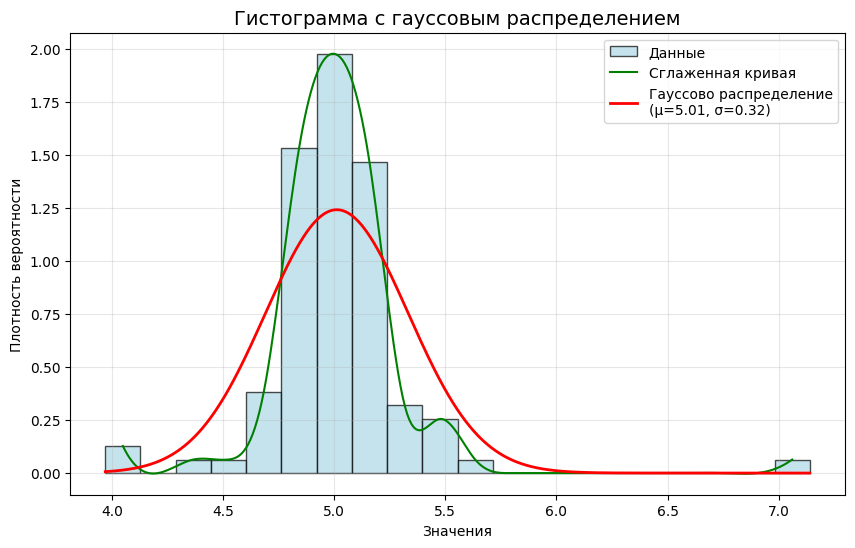

In [13]:
def plot_histogram_with_gaussian(data, bins='auto', figsize=(10, 6)):
    """
    Гистограмма с наложенным гауссовым распределением
    """
    # Убеждаемся, что работаем с numpy array
    if isinstance(data, pd.Series) or isinstance(data, pd.DataFrame):
        data = data.values.flatten()
    
    # Удаляем NaN значения
    data = data[~np.isnan(data)]

    
    
    # Рассчитываем параметры нормального распределения
    mu, sigma = np.mean(data), np.std(data)
    
    plt.figure(figsize=figsize)
    
    # Строим гистограмму (нормированную)
    n, bins, patches = plt.hist(data, bins=bins, density=True, alpha=0.7, 
                               color='lightblue', edgecolor='black', 
                               label='Данные')

    bin_centers = (bins[:-1] + bins[1:]) / 2
    spline = CubicSpline(bin_centers, n)
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 300)
    y_smooth = spline(x_smooth)
    plt.plot(x_smooth, y_smooth, 'green', label='Сглаженная кривая')
    
    # Создаем кривую нормального распределения
    x = np.linspace(np.min(data), np.max(data), 1000)
    y = stats.norm.pdf(x, mu, sigma)
    
    # Рисуем гауссово распределение 
    plt.plot(x, y, 'r-', linewidth=2, label=f'Гауссово распределение\n(μ={mu:.2f}, σ={sigma:.2f})')
    
    # Настройки графика
    plt.title('Гистограмма с гауссовым распределением', fontsize=14)
    plt.xlabel('Значения')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    return mu, sigma

mu, sigma = plot_histogram_with_gaussian(df)

In [27]:
print(f'Среднее значение {mu}, Дисперсия {sigma}')

Среднее значение 5.011919191919192, Дисперсия 0.3214979986983181


In [31]:
def remove_outliers_3sigma(data, sigma_level=3, return_mask=False):
    """
    Удаляет выбросы используя правило n-сигм
    
    Parameters:
    data: массив, Series или список с данными
    sigma_level: количество сигм для границы (по умолчанию 3)
    return_mask: если True, возвращает маску для фильтрации
    
    Returns:
    Очищенные данные или маску
    """
    # Преобразуем в numpy array и удаляем NaN
    if hasattr(data, 'values'):
        data_clean = data.values.flatten()
    else:
        data_clean = np.array(data).flatten()
    
    data_clean = data_clean[~np.isnan(data_clean)]
    
    if len(data_clean) == 0:
        return data_clean if not return_mask else (data_clean, np.array([]))
    
    # Вычисляем параметры распределения
    mu = np.mean(data_clean)
    sigma = np.std(data_clean)
    
    # Границы по правилу n-сигм
    lower_bound = mu - sigma_level * sigma
    upper_bound = mu + sigma_level * sigma
    
    # Создаем маску для данных внутри границ
    mask = (data_clean >= lower_bound) & (data_clean <= upper_bound)
    cleaned_data = data_clean[mask]
    
    print(f"Исходный размер: {len(data_clean)}")
    print(f"Очищенный размер: {len(cleaned_data)}")
    print(f"Удалено выбросов: {len(data_clean) - len(cleaned_data)}")
    print(f"Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Процент выбросов: {(1 - len(cleaned_data)/len(data_clean))*100:.2f}%")
    
    if return_mask:
        return cleaned_data, mask
    else:
        return cleaned_data

In [32]:
def preprocess_and_visualize(data, sigma_level=3, bins=30, figsize=(15, 10)):
    """
    Полный пайплайн: удаление выбросов + сравнение до/после
    """
    # Очищаем данные
    cleaned_data = remove_outliers_3sigma(data, sigma_level)
    
    # Создаем фигуру с несколькими subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Исходные данные с гауссовым распределением
    if hasattr(data, 'values'):
        original_data = data.values.flatten()
    else:
        original_data = np.array(data).flatten()
    
    original_data = original_data[~np.isnan(original_data)]
    
    mu_orig, sigma_orig = np.mean(original_data), np.std(original_data)
    
    axes[0, 0].hist(original_data, bins=bins, density=True, alpha=0.7, 
                   color='lightcoral', edgecolor='black', label='Исходные данные')
    
    x_orig = np.linspace(original_data.min(), original_data.max(), 1000)
    y_orig = stats.norm.pdf(x_orig, mu_orig, sigma_orig)
    axes[0, 0].plot(x_orig, y_orig, 'r-', linewidth=2, 
                   label=f'N(μ={mu_orig:.2f}, σ={sigma_orig:.2f})')
    
    # Добавляем границы 3σ
    lower_orig = mu_orig - sigma_level * sigma_orig
    upper_orig = mu_orig + sigma_level * sigma_orig
    axes[0, 0].axvline(lower_orig, color='blue', linestyle='--', alpha=0.7, label=f'±{sigma_level}σ')
    axes[0, 0].axvline(upper_orig, color='blue', linestyle='--', alpha=0.7)
    
    axes[0, 0].set_title('Исходные данные с выбросами', fontsize=12)
    axes[0, 0].set_xlabel('Значения')
    axes[0, 0].set_ylabel('Плотность вероятности')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Очищенные данные с гауссовым распределением
    mu_clean, sigma_clean = np.mean(cleaned_data), np.std(cleaned_data)
    
    axes[0, 1].hist(cleaned_data, bins=bins, density=True, alpha=0.7, 
                   color='lightgreen', edgecolor='black', label='Очищенные данные')
    
    x_clean = np.linspace(cleaned_data.min(), cleaned_data.max(), 1000)
    y_clean = stats.norm.pdf(x_clean, mu_clean, sigma_clean)
    axes[0, 1].plot(x_clean, y_clean, 'g-', linewidth=2, 
                   label=f'N(μ={mu_clean:.2f}, σ={sigma_clean:.2f})')
    
    axes[0, 1].set_title('Данные после удаления выбросов', fontsize=12)
    axes[0, 1].set_xlabel('Значения')
    axes[0, 1].set_ylabel('Плотность вероятности')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Box plot сравнение
    box_data = [original_data, cleaned_data]
    axes[1, 0].boxplot(box_data, labels=['С выбросами', 'Без выбросов'])
    axes[1, 0].set_title('Box plot сравнение', fontsize=12)
    axes[1, 0].set_ylabel('Значения')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. QQ-plot для очищенных данных
    stats.probplot(cleaned_data, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot очищенных данных', fontsize=12)
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return cleaned_data

Исходный размер: 99
Очищенный размер: 97
Удалено выбросов: 2
Границы: [4.05, 5.98]
Процент выбросов: 2.02%


/tmp/ipykernel_59496/1868401538.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=['С выбросами', 'Без выбросов'])


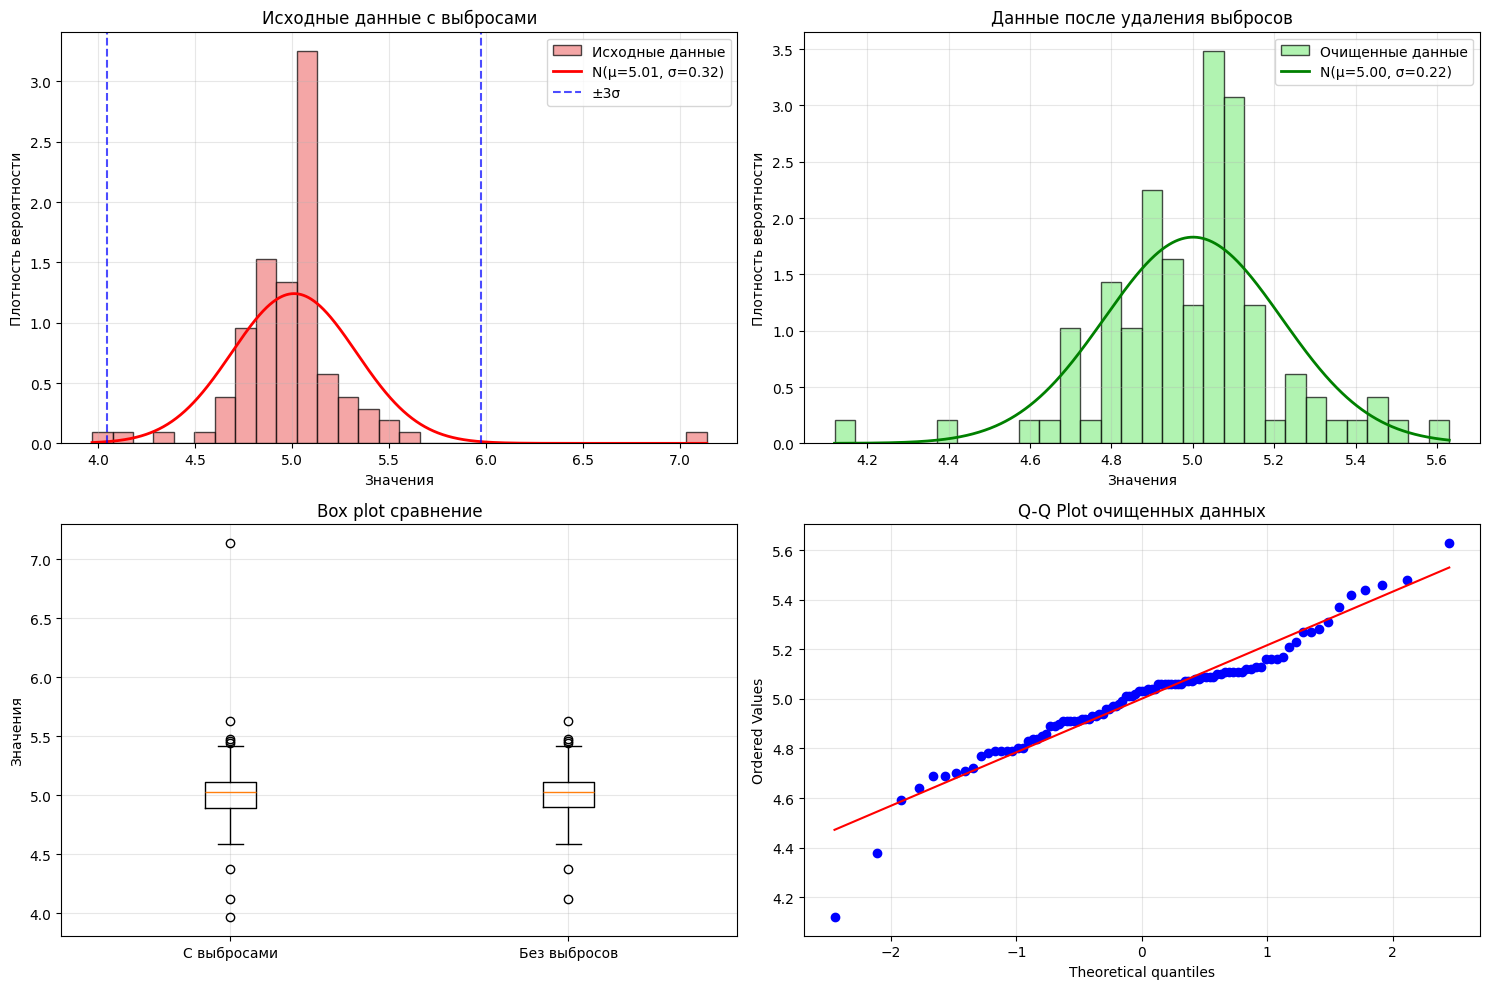

array([5.42, 4.38, 4.7 , 5.1 , 5.28, 4.97, 4.72, 5.23, 5.01, 5.12, 5.08,
       4.91, 5.11, 5.17, 4.69, 5.09, 4.89, 4.89, 4.77, 5.27, 5.01, 5.06,
       4.99, 5.48, 5.46, 4.59, 5.11, 5.04, 5.06, 5.01, 5.09, 5.02, 4.84,
       5.09, 5.07, 4.79, 5.21, 4.92, 4.86, 5.04, 4.97, 5.12, 5.44, 4.85,
       4.69, 4.79, 5.16, 4.12, 5.31, 5.11, 4.79, 5.16, 4.78, 5.16, 4.94,
       4.71, 4.64, 5.63, 5.04, 4.94, 4.91, 5.06, 4.96, 4.84, 5.13, 5.06,
       4.79, 5.06, 4.98, 5.11, 4.96, 5.03, 5.11, 5.37, 4.8 , 5.13, 4.83,
       5.27, 4.8 , 4.93, 4.91, 5.06, 5.07, 5.08, 4.93, 4.92, 5.07, 5.03,
       5.03, 4.91, 5.06, 4.92, 5.06, 4.9 , 5.1 , 4.91, 5.09])

In [33]:
preprocess_and_visualize(df)